In [1]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import implicit

In [2]:
INPUT_GRAPH_FILENAME = "starwars.graphml"
# Read the graph in GraphML format
g_in = nx.read_graphml(INPUT_GRAPH_FILENAME)

# Re-label the nodes so they use the 'name' as label
g_relabeled = nx.relabel.relabel_nodes(g_in, dict(g_in.nodes(data='name')))

# Convert the graph to undirected
g = g_relabeled.to_undirected()

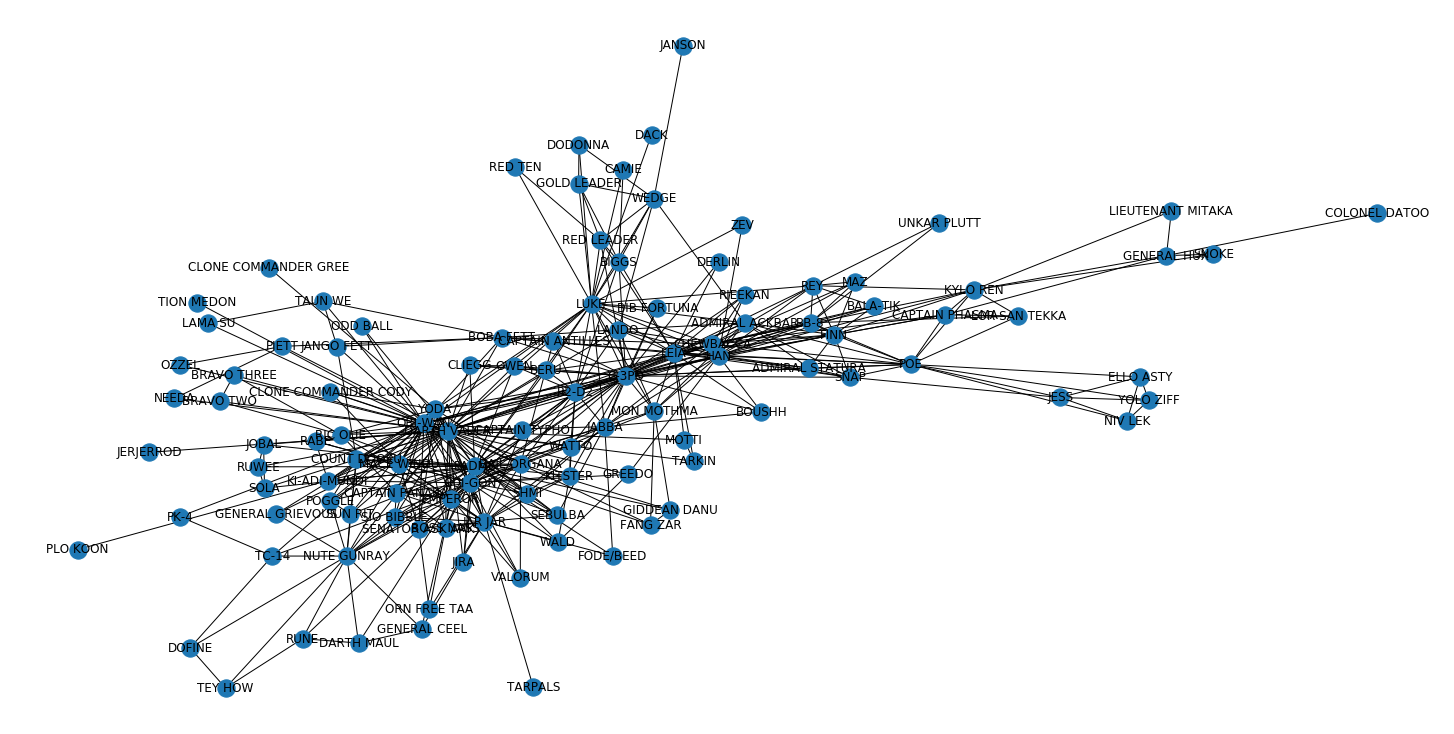

In [11]:
# Create a plot of 20x10
plt.figure(figsize=(20,10))

# Layout the nodes using a spring model
nx.draw_spring(g, with_labels=True)

# Display
_ = plt.show()

In [3]:
def split_graph(graph, p_test):
    E_test = int(len(graph.edges) * p_test)
    test_edge_list_split = random.sample(graph.edges(), E_test)
    test_edge_list = list(test_edge_list_split)
    # Remove some edges
    training_graph = graph.copy()
    training_graph.remove_edges_from(test_edge_list_split)
    test_graph = nx.Graph()
    test_graph.add_edges_from(test_edge_list)
    return training_graph, test_graph

In [4]:
train, test = split_graph(g, 0.20)
test.edges()

EdgeView([('BOSS NASS', 'DARTH VADER'), ('BOSS NASS', 'OBI-WAN'), ('DARTH VADER', 'LEIA'), ('DARTH VADER', 'WATTO'), ('DARTH VADER', 'BRAVO THREE'), ('DARTH VADER', 'JOBAL'), ('DARTH VADER', 'JERJERROD'), ('DARTH VADER', 'GREEDO'), ('DARTH VADER', 'PIETT'), ('DARTH VADER', 'SUN RIT'), ('DARTH VADER', 'KITSTER'), ('DARTH VADER', 'SEBULBA'), ('DARTH VADER', 'SHMI'), ('DARTH VADER', 'OZZEL'), ('DARTH VADER', 'MACE WINDU'), ('DARTH VADER', 'CAPTAIN PANAKA'), ('WATTO', 'R2-D2'), ('WATTO', 'KITSTER'), ('R2-D2', 'BAIL ORGANA'), ('R2-D2', 'C-3PO'), ('R2-D2', 'LEIA'), ('R2-D2', 'CAPTAIN ANTILLES'), ('LEIA', 'C-3PO'), ('LEIA', 'REY'), ('LANDO', 'BOBA FETT'), ('LANDO', 'ADMIRAL ACKBAR'), ('LANDO', 'WEDGE'), ('BOBA FETT', 'PIETT'), ('BIB FORTUNA', 'JABBA'), ('JABBA', 'SEBULBA'), ('JABBA', 'CHEWBACCA'), ('JABBA', 'PADME'), ('YODA', 'PADME'), ('YODA', 'KI-ADI-MUNDI'), ('YODA', 'JAR JAR'), ('PADME', 'COUNT DOOKU'), ('PADME', 'NUTE GUNRAY'), ('PADME', 'JAR JAR'), ('PADME', 'CLIEGG'), ('SNOKE', 'GENERA

In [31]:
def pagerank(g_train, g_test):
    recommendations = {}
    N_test = len(g_test.nodes())
    pr = nx.pagerank(g_train,personalization={node: 1/N_test for node in g_test.nodes()})
    return pr

def pagerank2(g_train, g_test):
    recommendations = {}
    N_test = len(g_test.nodes())
    score = {}
    for node in g_test.nodes():
        score[node] = nx.pagerank(g_train,personalization={node: 1})
    return score

In [5]:
def friends_of_friends(start, graph):
    friends1 = set(graph.neighbors(start))
    friends = set(friends1)
    for friend in friends1:
        friends = friends.union(set(graph.neighbors(friend)))
    friends.remove(start)
    return friends

In [20]:
def adamic_adar(g_train, g_test, graph, K=10):
    edges = set()
    for node in g_test.nodes():
        edges = edges.union({(node, friend) for friend in friends_of_friends(node, graph)})
    preds = nx.adamic_adar_index(g_train, list(edges))
    recommendation = {}
    for u, v, p in preds:
        if u not in recommendation:
            recommendation[u] = []
        recommendation[u].append((v, p))
    for u, rank in recommendation.items():
        rank.sort(key=lambda x: x[1], reverse=True)
        recommendation[u] = rank[:K]
    return recommendation

In [18]:
def als(g_train, g_test, graph, K=10):
    als = implicit.als.AlternatingLeastSquares()
    als.fit(nx.adjacency_matrix(g_train, nodelist=graph.nodes()))
    index = {node:i for i, node in enumerate(graph.nodes())}
    A = nx.adjacency_matrix(graph)
    recommendations = {}
    for node in g_test.nodes():
        ff = [index[friend] for friend in friends_of_friends(node, graph)]
        rank = als.rank_items(index[node], A, ff)
        recommendations[node] = [(list(graph.nodes())[i], score) for i, score in rank[:K]]
    return recommendations
    

In [7]:
def get_recommendations(start, graph, score, K=10):
    friends = friends_of_friends(start, graph)
    node_scores = [(node, score[node]) for node in friends]
    node_scores.sort(key=lambda x: x[1], reverse=True)
    return node_scores[:K]

def get_recommendations2(start, graph, score, K=10):
    friends1 = set(graph.neighbors(start))
    friends = set(friends1)
    for friend in friends1:
        friends = friends.union(set(graph.neighbors(friend)))
    score = score[start]
    node_scores = [(node, score.get(node, 0)) for node in friends]
    node_scores.sort(key=lambda x: x[1], reverse=True)
    return node_scores[:K]

In [35]:
pr = pagerank2(train, test)
print(get_recommendations2('WEDGE', g, pr))

[('WEDGE', 0.2024177390994998), ('LUKE', 0.0790492527302739), ('RED LEADER', 0.05317268797632009), ('BIGGS', 0.053075743819224135), ('GOLD LEADER', 0.049728302934720275), ('LANDO', 0.03695265572866173), ('C-3PO', 0.032062411480177244), ('LEIA', 0.03112672050272453), ('JANSON', 0.0286755444920918), ('DARTH VADER', 0.026761151543075398)]


In [38]:
print(get_recommendations2('REY', g, pr))

[('REY', 0.1869276305857914), ('HAN', 0.06491625738022659), ('BB-8', 0.054804548997142884), ('CHEWBACCA', 0.048095885615836276), ('LEIA', 0.04645703175526083), ('KYLO REN', 0.039809350884978695), ('MAZ', 0.03161320772572484), ('BALA-TIK', 0.029539244743756674), ('C-3PO', 0.02941091312742053), ('DARTH VADER', 0.02460320951349331)]


In [21]:
adamic = adamic_adar(train, test, g)
adamic['REY']

[('BB-8', 3.980604512377299),
 ('HAN', 2.558221716932459),
 ('CHEWBACCA', 2.458209131047589),
 ('POE', 2.1189789695408288),
 ('FINN', 1.816561951043854),
 ('LEIA', 1.8083115022610228),
 ('C-3PO', 1.4390421291921678),
 ('R2-D2', 1.405881897879178),
 ('MAZ', 1.1283746619123618),
 ('BALA-TIK', 1.095214430599372)]

In [19]:
als_recom = als(train, test, g)
als_recom['BB-8']

[('UNKAR PLUTT', 1.0073328),
 ('KYLO REN', 1.0067617),
 ('HAN', 1.0047128),
 ('FINN', 1.003191),
 ('CHEWBACCA', 1.0013889),
 ('LUKE', 1.0000231),
 ('BALA-TIK', 0.9961901),
 ('MAZ', 0.990245),
 ('BB-8', 0.98687637),
 ('CAPTAIN PHASMA', 0.01638712)]

In [25]:
als_recom['EMPEROR']

[('DARTH MAUL', 1.0104179),
 ('NUTE GUNRAY', 1.0040338),
 ('CAPTAIN PANAKA', 1.004005),
 ('MACE WINDU', 1.0039134),
 ('COUNT DOOKU', 1.0038819),
 ('LUKE', 1.0037434),
 ('BAIL ORGANA', 1.0034322),
 ('DARTH VADER', 1.0019405),
 ('PADME', 1.0017262),
 ('R2-D2', 1.0012969)]

In [3]:
g = nx.Graph()
g.add_edges_from([(1, 2), (1, 3)])

In [5]:
g.nodes()

NodeView((1, 2, 3))